<a href="https://colab.research.google.com/github/lisboalau01/Esteganografia/blob/main/DWT_estego.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# DWT

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 20.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import cv2
import pywt
import os
import matplotlib.pyplot as plt

def adjust_image_size(image):
    """Garante que a imagem tenha dimensões múltiplas de 4."""
    rows, cols = image.shape
    new_rows = rows + (4 - rows % 4) if rows % 4 != 0 else rows
    new_cols = cols + (4 - cols % 4) if cols % 4 != 0 else cols
    return cv2.resize(image, (new_cols, new_rows))

def split_image(image, block_size=512, overlap=32):
    h, w = image.shape
    blocks = []
    for i in range(0, h - block_size, block_size - overlap):
        for j in range(0, w - block_size, block_size - overlap):
            block = image[i:i+block_size, j:j+block_size]
            blocks.append((i, j, block))
    return blocks, h, w

def merge_image(blocks, h, w, block_size=512, overlap=32):
    image = np.zeros((h, w), dtype=np.float32)
    count = np.zeros((h, w), dtype=np.float32)
    for (i, j, block) in blocks:
        image[i:i+block.shape[0], j:j+block.shape[1]] += block
        count[i:i+block.shape[0], j:j+block.shape[1]] += 1
    return np.divide(image, count, out=np.zeros_like(image), where=count!=0)

def prepare_image(image_path):
    # Lê a imagem em grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Erro ao carregar a imagem: {image_path}")
    img = adjust_image_size(img)
    img = img.astype(np.float32) / 255.0
    return img

def message_to_binary(message):
    """Converte uma mensagem em binário e adiciona um terminador."""
    return ''.join(format(ord(char), '08b') for char in message) + '00000000'

def embed_bit_in_wavelet(coeffs, bit, alpha=0.25):
    cA, (cH, cV, cD) = coeffs
    target_region = cH[:2, :2]
    avg_value = np.mean(target_region)
    if bit == '1':
        target_region[:] = avg_value + alpha
    else:
        target_region[:] = avg_value - alpha
    return cA, (cH, cV, cD)

# Alteramos para retornar todas as linhas do arquivo
def read_messages_from_txt_dwt(txt_path):
    with open(txt_path, 'r', encoding='utf-8') as file:
        lines = [line.strip() for line in file if line.strip()]
    return lines

# Mesmo helper para obter 5 linhas
def get_message_for_image(mensagens, start, count=5):
    total = len(mensagens)
    lines = []
    for i in range(count):
        lines.append(mensagens[(start + i) % total])
    return '\n'.join(lines)

def encode_images_in_folder(input_folder, txt_path, output_folder, block_size=512, overlap=32):
    os.makedirs(output_folder, exist_ok=True)
    mensagens = read_messages_from_txt_dwt(txt_path)
    pointer = 0
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            image_path = os.path.join(input_folder, filename)
            img = prepare_image(image_path)
            mensagem = get_message_for_image(mensagens, pointer, count=5)
            pointer = (pointer + 5) % len(mensagens)
            binary_message = message_to_binary(mensagem)
            blocks, h, w = split_image(img, block_size, overlap)
            bit_count = 0
            modified_blocks = []
            for (i, j, block) in blocks:
                modified_block = block.copy()
                for x in range(0, block.shape[0] - 4, 4):
                    for y in range(0, block.shape[1] - 4, 4):
                        if bit_count < len(binary_message):
                            sub_block = block[x:x+4, y:y+4]
                            coeffs = pywt.dwt2(sub_block, 'haar')
                            modified_coeffs = embed_bit_in_wavelet(coeffs, binary_message[bit_count])
                            modified_sub_block = pywt.idwt2(modified_coeffs, 'haar')
                            if modified_sub_block.shape == (4, 4):
                                modified_block[x:x+4, y:y+4] = modified_sub_block
                                bit_count += 1
                modified_blocks.append((i, j, modified_block))
            modified_img = merge_image(modified_blocks, h, w, block_size, overlap)
            output_file = os.path.join(output_folder, f"esteganografada_{filename}")
            cv2.imwrite(output_file, np.clip(modified_img * 255.0, 0, 255).astype(np.uint8))
            print(f"Imagem esteganografada salva: {output_file}")

def decode_image(image_path, block_size=512, overlap=32):
    image = prepare_image(image_path)
    binary_message = ""
    message = ""
    null_count = 0
    blocks, _, _ = split_image(image, block_size, overlap)
    for (i, j, block) in blocks:
        for x in range(0, block.shape[0] - 4, 4):
            for y in range(0, block.shape[1] - 4, 4):
                sub_block = block[x:x+4, y:y+4]
                coeffs = pywt.dwt2(sub_block, 'haar')
                avg_value = np.mean(coeffs[1][0][:2, :2])
                std_dev = np.std(coeffs[1][0])
                bit = '1' if avg_value > std_dev else '0'
                binary_message += bit
                if len(binary_message) >= 8:
                    char_bits = binary_message[:8]
                    binary_message = binary_message[8:]
                    if char_bits == '00000000':
                        null_count += 1
                        if null_count >= 2:
                            return message
                    else:
                        message += chr(int(char_bits, 2))
    return message

def decode_images_in_folder(folder):
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            image_path = os.path.join(folder, filename)
            message = decode_image(image_path)
            print(f"Mensagem extraída da imagem {filename}: {message}")

if __name__ == "__main__":
    input_folder = '/content/drive/MyDrive/esteganografia/Esteganografia_DWT/DWT'  # Altere para o caminho correto
    output_folder = '/content/drive/MyDrive/esteganografia/Esteganografia_DWT/M_DWT'   # Altere para o caminho desejado
    txt_path = '/content/drive/MyDrive/esteganografia/mensagem3.txt'  # Arquivo de mensagem
    encode_images_in_folder(input_folder, txt_path, output_folder)
    decode_images_in_folder(output_folder)


Imagem esteganografada salva: /content/drive/MyDrive/esteganografia/Esteganografia_DWT/M_DWT/esteganografada_img000.jpg
Imagem esteganografada salva: /content/drive/MyDrive/esteganografia/Esteganografia_DWT/M_DWT/esteganografada_img001.jpg
Imagem esteganografada salva: /content/drive/MyDrive/esteganografia/Esteganografia_DWT/M_DWT/esteganografada_img002.jpg
Imagem esteganografada salva: /content/drive/MyDrive/esteganografia/Esteganografia_DWT/M_DWT/esteganografada_img003.jpg
Imagem esteganografada salva: /content/drive/MyDrive/esteganografia/Esteganografia_DWT/M_DWT/esteganografada_img004.jpg
Imagem esteganografada salva: /content/drive/MyDrive/esteganografia/Esteganografia_DWT/M_DWT/esteganografada_img005.jpg
Imagem esteganografada salva: /content/drive/MyDrive/esteganografia/Esteganografia_DWT/M_DWT/esteganografada_img006.jpg
Imagem esteganografada salva: /content/drive/MyDrive/esteganografia/Esteganografia_DWT/M_DWT/esteganografada_img007.jpg
Imagem esteganografada salva: /content/d

# 1. Preparação do Dataset


In [ ]:
import os
import random
import pandas as pd
from sklearn.model_selection import train_test_split

def create_dataset(original_folder, stego_folder, test_size=0.2, val_size=0.1, random_state=41):
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    original_files = [os.path.join(original_folder, f)
                      for f in os.listdir(original_folder)
                      if f.lower().endswith(image_extensions)]
    stego_files = [os.path.join(stego_folder, f)
                   for f in os.listdir(stego_folder)
                   if f.lower().endswith(image_extensions)]
    data = []
    for filepath in original_files:
        data.append({'filepath': filepath, 'label': 0})
    for filepath in stego_files:
        data.append({'filepath': filepath, 'label': 1})
    random.seed(random_state)
    random.shuffle(data)
    df = pd.DataFrame(data)
    train_val, test = train_test_split(df, test_size=test_size,
                                        random_state=random_state,
                                        stratify=df['label'])
    train, val = train_test_split(train_val, test_size=val_size,
                                  random_state=random_state,
                                  stratify=train_val['label'])
    train.to_csv('train_dataset.csv', index=False)
    val.to_csv('val_dataset.csv', index=False)
    test.to_csv('test_dataset.csv', index=False)

    print("Datasets criados com sucesso:")
    print(f" - Treino: {len(train)} imagens")
    print(f" - Validação: {len(val)} imagens")
    print(f" - Teste: {len(test)} imagens")

if __name__ == "__main__":
    original_folder = '/content/drive/MyDrive/esteganografia/Esteganografia_DWT/DWT'
    stego_folder = '/content/drive/MyDrive/esteganografia/Esteganografia_DWT/M_DWT'

    create_dataset(original_folder, stego_folder)


Datasets criados com sucesso:
 - Treino: 202 imagens
 - Validação: 23 imagens
 - Teste: 57 imagens


# 2. Pré-processamento das Imagens


In [ ]:
import tensorflow as tf
import pandas as pd

def preprocess_image(image_path, target_size=(128, 128)):
    image = tf.io.read_file(image_path)
    # Converter para 3 canais se necessário; para este pipeline usaremos grayscale:
    image = tf.image.decode_png(image, channels=1)  # Grayscale
    image = tf.image.resize(image, target_size)
    image = image / 255.0
    return image

def load_dataset(csv_file, target_size=(128, 128), batch_size=32, shuffle=True):
    df = pd.read_csv(csv_file)
    filepaths = df['filepath'].tolist()
    labels = df['label'].tolist()
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    def _process(filepath, label):
        image = preprocess_image(filepath, target_size)
        return image, label
    ds = ds.map(_process, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(filepaths))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

if __name__ == "__main__":
    train_csv = 'train_dataset.csv'
    train_ds = load_dataset(train_csv, target_size=(128, 128), batch_size=32)
    for images, labels in train_ds.take(1):
        print("Shape do batch de imagens:", images.shape)
        print("Rótulos:", labels.numpy())


Shape do batch de imagens: (32, 128, 128, 1)
Rótulos: [0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0]


# 3. Extração de Features

In [ ]:
import cv2
import numpy as np
import scipy.stats as stats
from PIL import Image
import pandas as pd

def extract_features(image_path):
    """
    Extrai features simples de uma imagem para detecção de esteganografia.

    O processo:
      1. Carrega a imagem em escala de cinza.
      2. Normaliza os pixels para o intervalo [0, 1].
      3. Aplica um filtro Laplaciano para extrair resíduos de alta frequência.
      4. Calcula estatísticas (média, variância, skewness e kurtosis) tanto da imagem original quanto do resultado do filtro.

    Parâmetros:
      image_path (str): Caminho para a imagem.

    Retorna:
      dict: Dicionário contendo as features extraídas.
    """
    # Carrega a imagem em escala de cinza usando OpenCV
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Não foi possível carregar a imagem: {image_path}")

    # Normaliza a imagem para [0,1]
    img = img.astype(np.float32) / 255.0

    # Aplica o filtro Laplaciano para realçar as transições (resíduos)
    laplacian = cv2.Laplacian(img, cv2.CV_32F)

    # Estatísticas da imagem original
    mean_orig = np.mean(img)
    var_orig = np.var(img)
    skew_orig = stats.skew(img.flatten())
    kurt_orig = stats.kurtosis(img.flatten())

    # Estatísticas da imagem filtrada (Laplaciano)
    mean_lap = np.mean(laplacian)
    var_lap = np.var(laplacian)
    skew_lap = stats.skew(laplacian.flatten())
    kurt_lap = stats.kurtosis(laplacian.flatten())

    features = {
        'mean_orig': mean_orig,
        'var_orig': var_orig,
        'skew_orig': skew_orig,
        'kurt_orig': kurt_orig,
        'mean_lap': mean_lap,
        'var_lap': var_lap,
        'skew_lap': skew_lap,
        'kurt_lap': kurt_lap
    }
    return features

def create_features_dataset(csv_file, output_features_csv):
    """
    Cria um dataset de features extraídas das imagens.

    Lê um arquivo CSV com os caminhos das imagens e os rótulos, extrai as features de cada imagem
    e salva os resultados em um novo CSV.

    Parâmetros:
      csv_file (str): Caminho para o CSV que contém as colunas "filepath" e "label".
      output_features_csv (str): Caminho para salvar o CSV de features.
    """
    df = pd.read_csv(csv_file)
    features_list = []

    for index, row in df.iterrows():
        image_path = row['filepath']
        label = row['label']
        try:
            feats = extract_features(image_path)
            feats['filepath'] = image_path
            feats['label'] = label
            features_list.append(feats)
        except Exception as e:
            print(f"Erro ao extrair features da imagem {image_path}: {e}")

    features_df = pd.DataFrame(features_list)
    features_df.to_csv(output_features_csv, index=False)
    print(f"Dataset de features salvo em: {output_features_csv}")

# Exemplo de uso:
if __name__ == "__main__":
    # Supondo que você tenha um CSV 'train_dataset.csv' com colunas "filepath" e "label"
    csv_file = 'train_dataset.csv'
    output_features_csv = 'features_train.csv'

    create_features_dataset(csv_file, output_features_csv)


Dataset de features salvo em: features_train.csv


# 4. Treinamento do classificador



In [ ]:
# SVM
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Carrega o dataset de features (supondo que você gerou um CSV com features extraídas via SRM simplificado)
features_df = pd.read_csv('features_train.csv')  # Certifique-se de que este CSV contém as novas features

#
X = features_df.drop(['filepath', 'label'], axis=1)
y = features_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001, 0.0001]
}

svm = SVC(kernel='rbf', random_state=42)
grid_svm = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_svm.fit(X_train, y_train)

print("Melhores parâmetros SVM:", grid_svm.best_params_)
print("Acurácia média na validação (SVM):", grid_svm.best_score_)

y_pred = grid_svm.predict(X_test)
print("Matriz de Confusão - SVM:")
print(confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação - SVM:")
print(classification_report(y_test, y_pred))
print("\nAcurácia - SVM:")
print(accuracy_score(y_test, y_pred))

#######################################################

# randon forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)

print("Melhores parâmetros RF:", grid_rf.best_params_)
print("Acurácia média na validação (RF):", grid_rf.best_score_)

y_pred_rf = grid_rf.predict(X_test)
print("Matriz de Confusão - Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nRelatório de Classificação - Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("\nAcurácia - Random Forest:")
print(accuracy_score(y_test, y_pred_rf))

Melhores parâmetros SVM: {'C': 1, 'gamma': 0.01}
Acurácia média na validação (SVM): 0.6892045454545455
Matriz de Confusão - SVM:
[[16  5]
 [ 5 15]]

Relatório de Classificação - SVM:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        21
           1       0.75      0.75      0.75        20

    accuracy                           0.76        41
   macro avg       0.76      0.76      0.76        41
weighted avg       0.76      0.76      0.76        41


Acurácia - SVM:
0.7560975609756098
Melhores parâmetros RF: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Acurácia média na validação (RF): 0.8068181818181819
Matriz de Confusão - Random Forest:
[[17  4]
 [ 4 16]]

Relatório de Classificação - Random Forest:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        21
           1       0.80      0.80      0.80        20

    accuracy                           0.80     

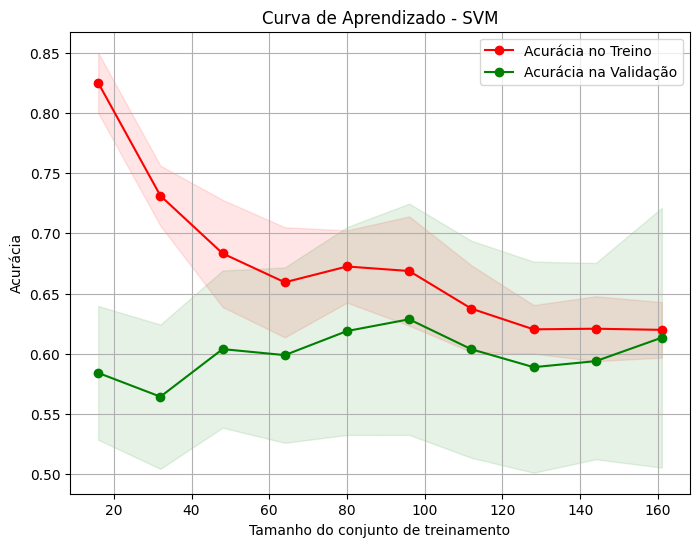

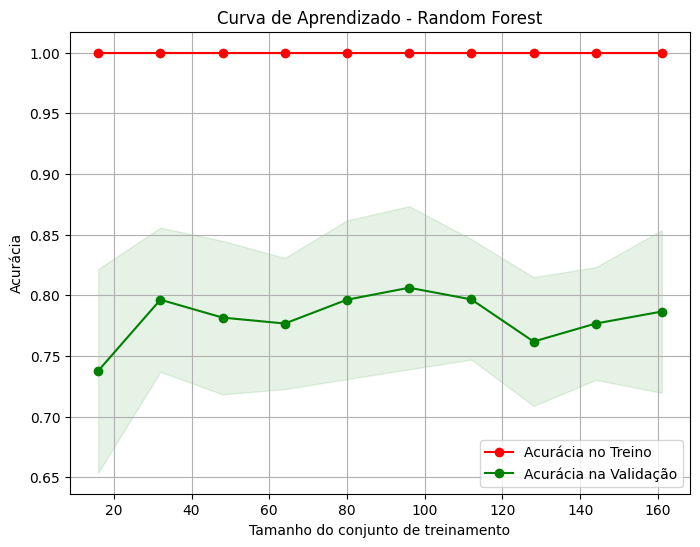

(array([ 16,  32,  48,  64,  80,  96, 112, 128, 144, 161]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([0.73768293, 0.79634146, 0.78158537, 0.77670732, 0.79634146,
        0.80621951, 0.79658537, 0.76182927, 0.77670732, 0.78658537]))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Plota a curva de aprendizado do modelo.

    Parâmetros:
      estimator: O modelo que será avaliado.
      title (str): Título do gráfico.
      X: Dados de entrada.
      y: Rótulos.
      cv (int): Número de folds para validação cruzada.
      n_jobs: Número de jobs a serem executados em paralelo.
      train_sizes: Frações do conjunto de treinamento a serem usadas.
    """
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Tamanho do conjunto de treinamento")
    plt.ylabel("Acurácia")

    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Acurácia no Treino")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Acurácia na Validação")
    plt.legend(loc="best")
    plt.show()
    return train_sizes, train_scores_mean, validation_scores_mean

# Exemplo usando SVM:
# Suponha que X e y já estejam definidos (por exemplo, do seu dataset de features)
# Aqui, usamos os melhores parâmetros encontrados (C=1, gamma=0.001) como exemplo:
svm_model = SVC(kernel='rbf', C=1, gamma=0.001, random_state=42)
plot_learning_curve(svm_model, "Curva de Aprendizado - SVM", X, y, cv=5, n_jobs=-1)

# Exemplo usando Random Forest:
# Usando, por exemplo, os parâmetros encontrados (n_estimators=100, max_depth=None, min_samples_split=2)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)
plot_learning_curve(rf_model, "Curva de Aprendizado - Random Forest", X, y, cv=5, n_jobs=-1)
